# Generating galaxies with GalSim

We are using the same GalSim routine as for the [asymmetry project](https://github.com/astro-nova/asymmetry) with some changes to make the galaxies more realistic in terms of the size and distribution of the random clumps that are added. These generation functions are then saved to `galaxy_generator.py`.

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

# Astropy
from astropy.io import fits
from astropy.visualization import AsinhStretch, AsymmetricPercentileInterval

# Galsim
from galaxy_generator import simulate_perfect_galaxy, add_source_to_image, sky_noise

Load in a galaxy to compare our generated galaxies to. This is an HSC i-band observation.

In [2]:
gal_f = fits.open('data/J000318+004844.fits')
gal = gal_f[0].data

pxscale = 0.169
zp = 2.5*np.log10(gal_f[0].header['FLUXMAG0'])
gal_f.close()

Plot it using both the SB and the asinh stretch:

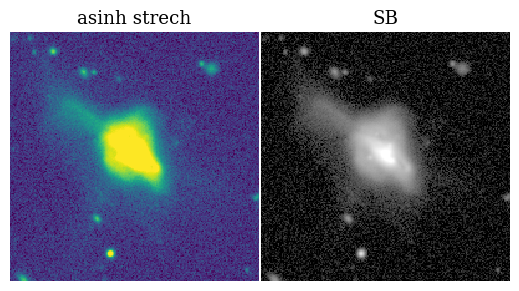

In [3]:
stretch = AsinhStretch(0.1)
norm = AsymmetricPercentileInterval(1, 99.6)
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(stretch(norm(gal)))
axs[1].imshow(-2.5*np.log10(np.abs(gal)/pxscale**2)+zp, cmap='gray_r', vmin=20, vmax=27)
axs[0].set_title('asinh strech')
axs[1].set_title('SB')
for ax in axs: 
    ax.axis('off')
    ax.set_xlim(238-100,238+100)
    ax.set_ylim(238-100,238+100)
plt.subplots_adjust(wspace=0.01)

## Generating a galaxy

The biggest changes from the previous model are:

* Clumps get fainter with radius away from the center as $(r/R_p)^\alpha$ 
    * $\alpha$ is something we can decide on. $\alpha \approx 2$ would follow a similar profile to the galaxy light; but we want asymmetric clumps to be a little flatter than that
    * Clump brightness is determined by *surface brightness* not *total flux* so that large clumps are not always much fainter than small ones. This would mean that the flux is distribution as $(r_{clump}/r_0)^2$ where $r_0$ is a typical clump size. 
    * However, we do want the clumps to be a little biased since large tidal features are typically faint, so we want some bias factor $(r_{clump}/r_0)^\beta$.
    
Overall, the clump flux $F$ is scaled by 

$$ F \propto \left( \frac{r}{R_p} \right)^{-\alpha} \left( \frac{r_{clump}}{r_0} \right)^{2-\beta}$$

The procedure is then:

1. Draw the fraction of the galaxy's total light contained in the clump, $f$, and radius, $r$.
2. Scale it up/down based on the clump radius itself (third bias)
3. Scale it down based on the radius from the galaxy center (first bias)
4. Calculate the total flux of the clump or pass the resulting fraction

Also, we now generate clumps to have logarithmically spaced sizes.

New clump generator function:

In [7]:
_default_clump_properties = {
    'r' : (0.05, 1.0),
    'logf' : (-3, -1), # From 1% to 10% of the tital light
    'logs' : (-1.5, 0.5) 
}

_default_galaxy_properties = {
    'mag' : (12, 17),
    'n_clumps' : (10, 100),
    'sersic_n' : (1, 5),
    'q' : (0.1, 1),
    'reff_scatter' : (0, 1.5) # Mean and standard deviation
}


def get_galaxy_rng_vals(
        N, lims=_default_galaxy_properties, 
        clump_props=_default_clump_properties, 
        alpha=1, beta=0.5, r0=1, seed=None):
    
    """Generate parameters to make N perfect galaxies. No SNR or PSF effects.
    Args:
        N (int) : number of samples
        lims (dict): dictionary with min and max limits for each parameter, see _default_galaxy_properties
        clump_props (dict): same, for inidividual clumps, see _default_clump_properties
        seed (int): random seed to use
    Returns:
        list[dict]: list containing N dictionaries with keys to pass to `simulate_perfect_galaxy'
    """

    # For any galaxy properties possibly not in user-supplied dict, populate with default
    for key, value in _default_galaxy_properties.items():
        if key not in lims:
            lims[key] = value
    for key, value in _default_clump_properties.items():
        if key not in clump_props:
            clump_props[key] = value

    # Using NumPy's new generator framework instead of np.random...
    rng = np.random.default_rng(seed=seed)

    #### Generate N samples with different distributions
    # Galaxy properties
    mags = rng.uniform(lims['mag'][0], lims['mag'][1], size=N)
    ns = rng.uniform(lims['sersic_n'][0], lims['sersic_n'][1], size=N)
    qs = rng.uniform(lims['q'][0], lims['q'][1], size=N)
    betas = rng.uniform(0, 2*np.pi, size=N)
    n_clumps = rng.integers(lims['n_clumps'][0], lims['n_clumps'][1]+1, size=N)
    rs = -1.9 * mags + 35 + rng.normal(lims['reff_scatter'][0], lims['reff_scatter'][1], size=N)

    # Clump properties for each galaxy
    clumps = []
    for i in range(N):
        num = n_clumps[i]
        clump_rs = rng.uniform(clump_props['r'][0], clump_props['r'][1], size=num)
        clump_fs = rng.uniform(clump_props['logf'][0], clump_props['logf'][1], size=num) #Log-uniform
        clump_size = rng.uniform(clump_props['logs'][0], clump_props['logs'][1], size=num)
        clump_theta = rng.uniform(0, 2*np.pi, size=num)
        clump_fs = np.power(10, clump_fs)
        clump_size = np.power(10, clump_size)
        
        # Rescale the clump flux based on its radius and distance
        clump_fs = clump_fs * np.power(clump_rs/0.5, -alpha) * np.power(clump_size/r0, 2-beta)
        
        clump_dict = {
            'r' : clump_rs, 'theta' : clump_theta, 'flux_frac' : clump_fs, 'sigma' : clump_size
        }
        clumps.append(clump_dict)

    # For high-sersic index cases, set q to 1
    qs[ns >= 3.5] = 1

    # Set lower and upper limits to the radius in arcseconds
    rs[rs < 1] = 1
    rs[rs > 20] = 20

    # Save all these values as output
    output = {
        'mag' : mags, 'r_eff' : rs, 'sersic_n' : ns, 'q' : qs, 
        'beta' : betas, 'n_clumps' : n_clumps, 'clump_properties' : clumps
    }

    # Convert to a list of dicts, where each dict can be passed to `simulate_perfect_galaxy`
    output = pd.DataFrame(output).to_dict(orient="records")
    return output

Generate and plot a galaxy:

In [8]:
pxscale = 0.1

params = get_galaxy_rng_vals(1, seed=12)[0]
img, sim_dict, rpet = simulate_perfect_galaxy(pxscale=pxscale, **params)
img, skylevel = sky_noise(img, 23, pxscale, rms_noise=True)

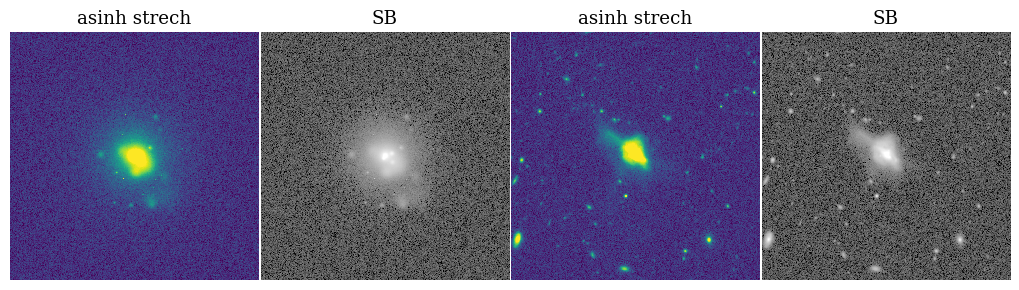

In [9]:
stretch = AsinhStretch(0.1)
norm = AsymmetricPercentileInterval(1, 99.6)
fig, axs = plt.subplots(1,4, figsize=(10,2.5))
axs[0].imshow(stretch(norm(img)))
axs[1].imshow(-2.5*np.log10(np.abs(img)/pxscale**2)+38, cmap='gray_r', vmin=17, vmax=27)
axs[2].imshow(stretch(norm(gal)))
axs[3].imshow(-2.5*np.log10(np.abs(gal)/0.04**2)+zp, cmap='gray_r', vmin=17, vmax=27)
axs[0].set_title('asinh strech')
axs[2].set_title('asinh strech')
axs[1].set_title('SB')
axs[3].set_title('SB')
for ax in axs: 
    ax.axis('off')
plt.subplots_adjust(wspace=0.01)

They look similar enough -- let's continue with this galaxy generation method.